## Functions

In [1]:
import pandas
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Rectangle
import numpy
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

#### Training and validation predictions

In [2]:
def plot_shaded_predictions(predictions_df, file_path):
    predictions = predictions_df['Predictions']  
    actuals = predictions_df['Actuals']  
    colors = {
        0: 'blue', 
        1: 'green', 
        2: 'red', 
        3: 'skyblue', 
        4: 'orange', 
    }
    fig, axs = plt.subplots(2, 1, figsize=(8, 2), sharex=True)
    # Plot predictions
    for i, value in enumerate(predictions):
        axs[0].add_patch(Rectangle((i, 0), 1, 1, color=colors.get(value, 'other')))
    # Plot actuals
    for i, value in enumerate(actuals):
        axs[1].add_patch(Rectangle((i, 0), 1, 1, color=colors.get(value, 'other')))
    # Setting the limits of the plot and other aesthetic settings
    for ax in axs:
        ax.set_xlim(0, max(len(predictions), len(actuals)))
        ax.set_ylim(0, 1)
        ax.yaxis.set_visible(False)
    # Adding a title
    axs[0].set_title('Predictions')
    axs[1].set_title('Actuals')
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()

#### Generate predictions

In [3]:
def generate_predictions(saving_path, final_results_folder, folder_names, weight_type):
    for weight in weight_type:
        for folder_name in folder_names:
            ### plot for first 2 training videos only
            video_ids = [1, 2]
            for video_id in video_ids:
                filename = f'training_predictions_{weight}.csv'
                training_predictions_df = pandas.read_csv(os.path.join(saving_path, final_results_folder, folder_name, filename))
                predictions_df = training_predictions_df[training_predictions_df['Video_ids'] == video_id]
                file_path = os.path.join(saving_path, final_results_folder, folder_name, f'training_shaded_plot_video{video_id}_{weight}.png')
                plot_shaded_predictions(predictions_df, file_path)
        
            filename = f'validation_predictions_{weight}.csv'
            validation_predictions_df = pandas.read_csv(os.path.join(saving_path, final_results_folder, folder_name, filename))
            video_ids = validation_predictions_df['Video_ids'].unique()
            for video_id in video_ids:
                predictions_df = validation_predictions_df[validation_predictions_df['Video_ids'] == video_id]
                file_path = os.path.join(saving_path, final_results_folder, folder_name, f'validation_shaded_plot_video{video_id}_{weight}.png')
                plot_shaded_predictions(predictions_df, file_path)


#### Confusion matrix generation

In [4]:
def compute_average_confusion_matrix(saving_path, final_results_folder, folder_name_set, weight_type, label_size):
    confusion_matrices = numpy.zeros((5, label_size, label_size))
    for i, folder_name in enumerate(folder_name_set):
        filename = f'predictions_vs_actuals_{weight_type}_model.csv'
        df = pandas.read_csv(os.path.join(saving_path, final_results_folder, folder_name, filename))
        y_actual = df['Actuals']
        y_pred = df['Predictions']
        cmatrix = confusion_matrix(y_actual, y_pred, labels=range(label_size))
        row_sums = cmatrix.sum(axis=1, keepdims=True)
        cmatrix_percentage = cmatrix / row_sums 
        # cmatrix_percentage *= 100
        confusion_matrices[i] += cmatrix_percentage
        print(cmatrix_percentage)
    mean = np.mean(confusion_matrices, axis=0)*100
    std_dev = np.std(confusion_matrices, axis=0)
    mean_std_dev = np.asarray([[f'{mean[i, j]:.1f}% ± {std_dev[i, j]:.2f}' for j in range(label_size)] 
                               for i in range(label_size)])
    #plt.figure(figsize=(8, 6))
    fig, ax = plt.subplots()
    sns.heatmap(mean, annot=mean_std_dev, fmt='', cmap='Blues', cbar=False)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    if label_size == 5:
        labels = ['debulk', 'medial', 'inferior', 'superior', 'lateral']
    elif label_size == 2:
        labels = ['debulk', 'dissection']
    elif label_size == 3:
        labels = ['approach', 'debulk and dissection', 'closure']
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    # plt.show()
    plt.savefig(os.path.join(saving_path, final_results_folder, f'{folder_name_set[0]}_av_confusion_matrix_{weight_type}.png'))
    plt.close()

In [5]:
def create_average_confusion_matrix(saving_path, final_results_folder, folder_name_sets, weight_type, label_size):
    for weight in weight_type:
        for folder_name_set in folder_name_sets:
            compute_average_confusion_matrix(saving_path, final_results_folder, folder_name_set, weight, label_size)

#### Metrics generation

In [6]:
def compute_average_metrics(saving_path, final_results_folder, folder_name_set, weight_type, label_size):
    step_matrices = numpy.zeros((5, label_size, 3))
    overall_matrices =  numpy.zeros((5, 1, 4))
    for i, folder_name in enumerate(folder_name_set):
        #temporal_smoothing_metrics_filename = f'temporal_smoothing_metrics_{weight_type}.csv'
        steps_metrics_filename = f'metrics_results_{weight_type}_model.csv'
        overall_results_filename = f'results_df_{weight_type}_model.csv'
        #temporal_smoothing_metrics = pandas.read_csv(os.path.join(saving_path, final_results_folder, folder_name, 
        #                                                          temporal_smoothing_metrics, temporal_smoothing_metrics_filename))
        #steps_df = temporal_smoothing_metrics
        steps_df = pandas.read_csv(os.path.join(saving_path, final_results_folder, folder_name, steps_metrics_filename))
        overall_df = pandas.read_csv(os.path.join(saving_path, final_results_folder, folder_name, overall_results_filename))
        print(os.path.join(saving_path, final_results_folder, folder_name, steps_metrics_filename))
        overall_df = pandas.read_csv(os.path.join(saving_path, final_results_folder, folder_name, overall_results_filename))
        step_matrices[i] += steps_df[['Precision', 'Recall', 'F1']].values
        overall_df['Run'] = folder_name.replace('_', ' ')
        overall_df = overall_df.rename(columns={'Unnamed: 0': 'Metric'})
        overall_df = overall_df.pivot(index='Run', columns='Metric', values='Value')
        overall_df = overall_df.reset_index()
        overall_matrices[i] += overall_df[['Weighted average F1', 'Overall accuracy', 'Weighted average precision', 'Weighted average recall']].values

    steps_mean = np.mean(step_matrices, axis=0)
    steps_std_dev = np.std(step_matrices, axis=0)
    
    # step metrics
    steps_results = pd.DataFrame(steps_mean).applymap("{:.2f}".format) + " ± " + pd.DataFrame(steps_std_dev).applymap("{:.2f}".format)
    steps_results.columns = ['Precision', 'Recall', 'F1']
    if label_size == 5:
        labels = ['tumour debulking', 'dissection medial', 'dissection inferior', 'dissection superior', 'dissection lateral']
    elif label_size == 2:
        labels = ['tumour debulking', 'dissection']
    elif label_size == 3:
        labels = ['approach', 'debulk and dissection', 'closure']
    steps_results['Category'] = labels
    steps_results = steps_results[['Category', 'Precision', 'Recall', 'F1']]
    
    steps_latex_output = steps_results.to_latex(index=False, header=['Category', 'Precision', 'Recall', 'F1'])
    print(steps_latex_output)
    with open(os.path.join(saving_path, final_results_folder, f'{folder_name_set[0]}_avg_steps_metrics_{weight_type}.tex'), 'w') as f:
        f.write(steps_latex_output)
    
    # overall metrics
    overall_mean = np.mean(overall_matrices, axis=0)
    overall_std_dev = np.std(overall_matrices, axis=0)
    overall_results = pd.DataFrame(overall_mean).applymap("{:.2f}".format) + " ± " + pd.DataFrame(overall_std_dev).applymap("{:.2f}".format)
    columns = ['Weighted average F1', 'Overall accuracy', 'Weighted average precision', 'Weighted average recall']
    overall_results.columns = columns
    overall_latex_output = overall_results.to_latex(index=False, header=columns)
    print(overall_latex_output)
    with open(os.path.join(saving_path, final_results_folder, f'{folder_name_set[0]}_avg_overall_metrics_{weight_type}.tex'), 'w') as f:
        f.write(overall_latex_output)

In [7]:
def create_average_metrics(saving_path, final_results_folder, folder_name_sets, weight_type, label_size):
    for weight in weight_type:
        for folder_name_set in folder_name_sets:
            compute_average_metrics(saving_path, final_results_folder, folder_name_set, weight, label_size)

#### Tensorboard results

In [71]:
def plot_tensorboard_results(results_df, tags, tag_ylim_min_map, tag_ylim_max_map, tag_map, run_map): #, label_map):
    for tag in tags:
        fig, ax = plt.subplots()
        data = results_df[results_df['Tag'] == tag]
        
        runs = data['Run'].unique()   
        # for run in runs: 
        #     run_data = data[data['Run'] == run]
        #     #run_data = run_data[['epoch','Value']]
        #     print(run_data)
        #     run_data = run_data.sort_values(by='epoch', ascending=True)
        #     print(run_data)
        #     print('plotting')
        #     ax.plot(run_data['epoch'], run_data['Value'], label=f'{run_map[run]}')
        for run in runs: 
            run_data = data[data['Run'] == run]
            # Group by 'epoch' and keep only the row with the max 'Wall time' for each group
            idx = run_data.groupby('epoch')['Wall time'].idxmax()  # replace 'Wall time' with your actual column name
            run_data = run_data.loc[idx]
            
            run_data = run_data.sort_values(by='epoch', ascending=True)
            ax.plot(run_data['epoch'], run_data['Value'], label=f'{run_map[run]}')
            
        y_min = tag_ylim_min_map[tag] if tag in tag_ylim_min_map else None
        y_max = tag_ylim_max_map[tag] if tag in tag_ylim_max_map else None
        if y_min is not None and y_max is not None:
            ax.set_ylim(tag_ylim_min_map[tag], tag_ylim_max_map[tag])
        # Set the title dynamically based on the tag
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title(f'{tag_map[tag]}')
        plt.legend()
    
        
        # Display the plot
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        tag = tag.replace(' ', '_')
        plt.savefig(os.path.join(saving_path, final_results_folder, f'{run_map[run]}_{tag}.png'))

#### All run executions

In [8]:
saving_path = '/Users/dorotheeduvaux 1/UCL CSML/MSc Project'
final_results_folder = 'FinalResults/extraResults/Jan2024Results'

In [20]:
folder_names = [
    # combined + phases - non-dynamic overall weights
    'new_network_inv_weights_refl_1fps_250_comb_1',
    'new_network_inv_weights_refl_1fps_250_phase_fold1',
    'rLSTM_batch30_intprop_ear_1fp250_combined_fold1',
    'rLSTM_batch30_intprop_ear_1fp250_phase_fold1',
    
    # steps - corrected weights
    'new_network_inv_weights_refl_1fps_250',
    'rLSTM_batch30_intprop_ear_1fp250_fold1',

    # steps - overall weights
    'new_network_inv_weights_refl_1fps_250_ow_fold1',
    'rLSTM_batch30_intprop_ear_1fp250_ow_fold1',
]

weight_type = ['best', 'last']

## Prediction generation
generate_predictions(saving_path, final_results_folder, folder_names, weight_type)


folder_names = [
    # combined + phases - non-dynamic overall weights
    'rLSTM_batch30_intprop_ear_1fp250_phase_fold1_coarse',
    'rLSTM_batch30_intprop_ear_1fp250_phase_fold2_coarse',
    'rLSTM_batch30_intprop_ear_1fp250_phase_fold3_coarse',
    'rLSTM_batch30_intprop_ear_1fp250_phase_fold4_coarse',
    'rLSTM_batch30_intprop_ear_1fp250_phase_fold5_coarse'
]
    
weight_type = ['best', 'last']

## Prediction generation
generate_predictions(saving_path, final_results_folder, folder_names, weight_type)


In [9]:
# ## Confusion matrix and metrics for combined steps
# weight_type = ['best', 'last']
# label_size=2
# folder_name_sets_combined_steps = [
#                   ['new_network_inv_weights_refl_1fps_250_comb_1',
#                   'new_network_inv_weights_refl_1fps_250_comb_2',
#                   'new_network_inv_weights_refl_1fps_250_comb_3',
#                   'new_network_inv_weights_refl_1fps_250_comb_4',
#                   'new_network_inv_weights_refl_1fps_250_comb_5'],
#                 ['rLSTM_batch30_intprop_ear_1fp250_combined_fold1',
#                 'rLSTM_batch30_intprop_ear_1fp250_combined_fold2',
#                 'rLSTM_batch30_intprop_ear_1fp250_combined_fold3',
#                 'rLSTM_batch30_intprop_ear_1fp250_combined_fold4',
#                 'rLSTM_batch30_intprop_ear_1fp250_combined_fold5'],
# ]
# create_average_confusion_matrix(saving_path, final_results_folder, folder_name_sets_combined_steps, weight_type, label_size)
# create_average_metrics(saving_path, final_results_folder, folder_name_sets_combined_steps, weight_type, label_size)

## Confusion matrix and metrics for coarse phases
weight_type = ['best', 'last']
label_size=3
folder_name_sets_phases = [
                ['rLSTM_batch30_intprop_ear_1fp250_phase_fold1_coarse',
                'rLSTM_batch30_intprop_ear_1fp250_phase_fold2_coarse',
                'rLSTM_batch30_intprop_ear_1fp250_phase_fold3_coarse',
                'rLSTM_batch30_intprop_ear_1fp250_phase_fold4_coarse',
                'rLSTM_batch30_intprop_ear_1fp250_phase_fold5_coarse']
]
create_average_confusion_matrix(saving_path, final_results_folder, folder_name_sets_phases, weight_type, label_size)
create_average_metrics(saving_path, final_results_folder, folder_name_sets_phases, weight_type, label_size)


# ## Confusion matrix and metrics for phases
# weight_type = ['best', 'last']
# label_size=3
# folder_name_sets_phases = [
#                 ['rLSTM_batch30_intprop_ear_1fp250_phase_fold1',
#                 'rLSTM_batch30_intprop_ear_1fp250_phase_fold2',
#                 'rLSTM_batch30_intprop_ear_1fp250_phase_fold3',
#                 'rLSTM_batch30_intprop_ear_1fp250_phase_fold4',
#                 'rLSTM_batch30_intprop_ear_1fp250_phase_fold5'],
#                 ['new_network_inv_weights_refl_1fps_250_phase_fold1',
#                  'new_network_inv_weights_refl_1fps_250_phase_fold2',
#                  'new_network_inv_weights_refl_1fps_250_phase_fold3',
#                  'new_network_inv_weights_refl_1fps_250_phase_fold4',
#                  'new_network_inv_weights_refl_1fps_250_phase_fold5',]
# ]
# create_average_confusion_matrix(saving_path, final_results_folder, folder_name_sets_phases, weight_type, label_size)
# create_average_metrics(saving_path, final_results_folder, folder_name_sets_phases, weight_type, label_size)


# ## Confusion matrix and metrics for steps - corrected weights
# weight_type = ['best', 'last']
# label_size=5
# folder_name_sets_steps = [
#                 ['new_network_inv_weights_refl_1fps_250',
#                 'new_nn_inv_weights_refl_1fps_250_fold2',
#                 'new_nn_inv_weights_refl_1fps_250_fold3',
#                 'new_nn_inv_weights_refl_1fps_250_fold4',
#                 'new_nn_inv_weights_refl_1fps_250_fold5'],
#                 ['rLSTM_batch30_intprop_ear_1fp250_fold1',
#                  'rLSTM_batch30_intprop_ear_1fp250_fold2',
#                  'rLSTM_batch30_intprop_ear_1fp250_fold3',
#                  'rLSTM_batch30_intprop_ear_1fp250_fold4',
#                  'rLSTM_batch30_intprop_ear_1fp250_fold5',]
# ]
# create_average_confusion_matrix(saving_path, final_results_folder, folder_name_sets_steps, weight_type, label_size)
# create_average_metrics(saving_path, final_results_folder, folder_name_sets_steps, weight_type, label_size)


# ## Confusion matrix and metrics for steps - overall weights
# weight_type = ['best', 'last']
# label_size=5
# folder_name_sets_steps_ow = [
#                 ['new_network_inv_weights_refl_1fps_250_ow_fold1',
#                 'new_nn_inv_weights_refl_1fps_250_ow_fold2',
#                 'new_nn_inv_weights_refl_1fps_250_ow_fold3',
#                 'new_nn_inv_weights_refl_1fps_250_ow_fold4',
#                 'new_nn_inv_weights_refl_1fps_250_ow_fold5'],
#                 ['rLSTM_batch30_intprop_ear_1fp250_ow_fold1',
#                  'rLSTM_batch30_intprop_ear_1fp250_ow_fold2',
#                  'rLSTM_batch30_intprop_ear_1fp250_ow_fold3',
#                  'rLSTM_batch30_intprop_ear_1fp250_ow_fold4',
#                  'rLSTM_batch30_intprop_ear_1fp250_ow_fold5',]
# ]
# create_average_confusion_matrix(saving_path, final_results_folder, folder_name_sets_steps_ow, weight_type, label_size)
# create_average_metrics(saving_path, final_results_folder, folder_name_sets_steps_ow, weight_type, label_size)

[[0.82352941 0.17647059 0.        ]
 [0.00923411 0.96686583 0.02390005]
 [0.08465608 0.26984127 0.64550265]]
[[0.8        0.2        0.        ]
 [0.03803132 0.95973154 0.00223714]
 [0.02758621 0.53103448 0.44137931]]
[[0.74301676 0.25698324 0.        ]
 [0.00217628 0.98585419 0.01196953]
 [0.01226994 0.66871166 0.3190184 ]]
[[0.91603053 0.08015267 0.00381679]
 [0.07842047 0.8971079  0.02447164]
 [0.02824859 0.41242938 0.55932203]]
[[0.88317757 0.11682243 0.        ]
 [0.00918233 0.98600787 0.00480979]
 [0.00819672 0.54508197 0.44672131]]
[[0.89839572 0.09625668 0.00534759]
 [0.01032048 0.8077132  0.18196632]
 [0.05291005 0.13227513 0.81481481]]
[[0.925      0.075      0.        ]
 [0.09731544 0.78747204 0.11521253]
 [0.0137931  0.36551724 0.62068966]]
[[0.98882682 0.01117318 0.        ]
 [0.11860718 0.81229597 0.06909684]
 [0.07361963 0.46625767 0.4601227 ]]
[[0.95419847 0.03053435 0.01526718]
 [0.12124583 0.73470523 0.14404894]
 [0.04519774 0.06214689 0.89265537]]
[[0.74766355 0.2523

In [56]:
### tensorboard
input_path = '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/FinalResults/extraResults/Jan2024Results/tensorboard/tensorboard_data_results.csv'
tensorboard_data_df = pandas.read_csv(input_path)

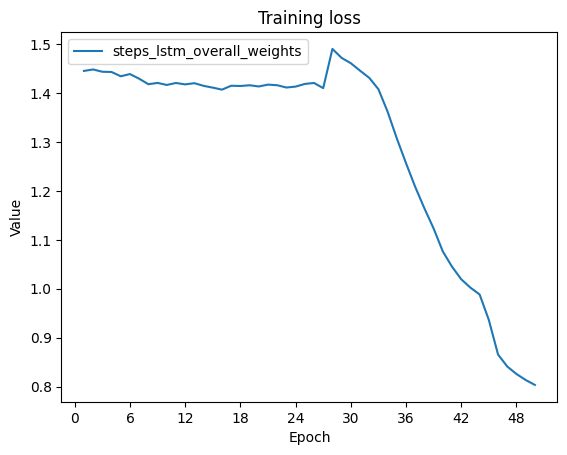

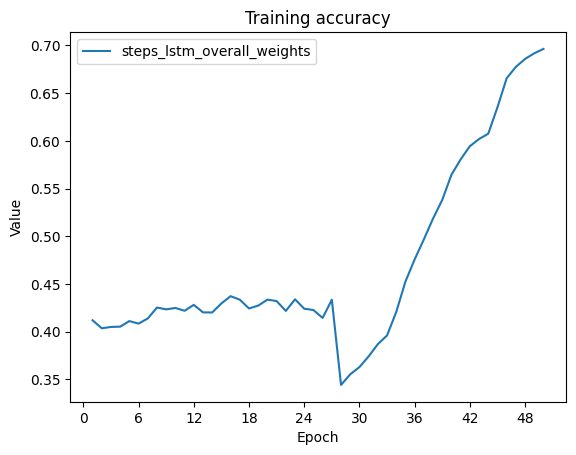

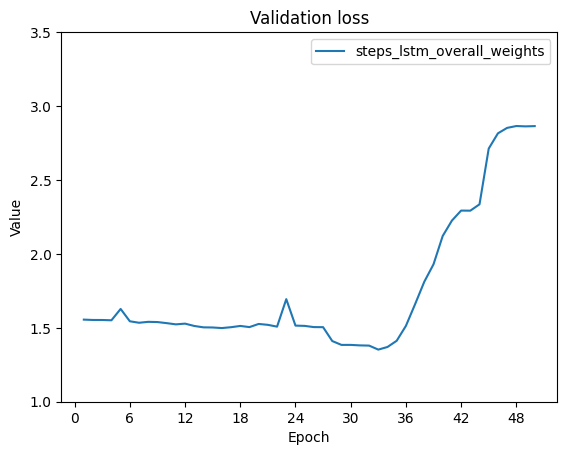

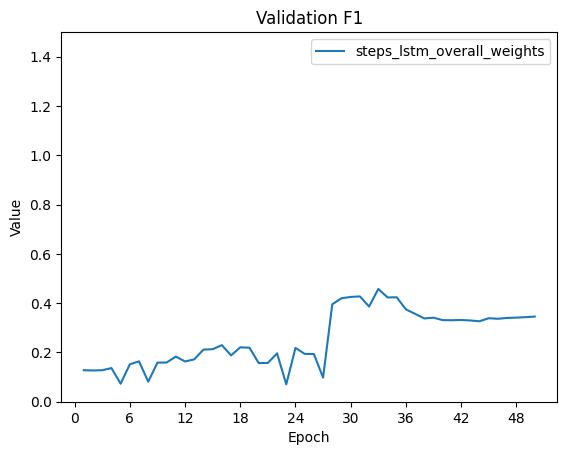

In [84]:
runs = [
    # combined + phases - non-dynamic overall weights
    #'new_network_inv_weights_refl_1fps_250_comb',
    #'new_network_inv_weights_refl_1fps_250_phase_fold1',
    #'rLSTM_batch30_intprop_ear_1fp250_combined_fold1',
    #'rLSTM_batch30_intprop_ear_1fp250_phase_fold1',
    
    # steps - corrected weights
    #'new_network_inv_weights_refl_1fps_250',
    #'rLSTM_batch30_intprop_ear_1fp250_fold1',

    # steps - overall weights
    #'new_network_inv_weights_refl_1fps_250_ow_fold1',
    'rLSTM_batch30_intprop_ear_1fp250_ow_fold1',
]

tags = ['training loss epoch ', 'training acc epoch', 'validation loss epoch ', 'validation f1 epoch']
tag_ylim_max_map = {
          # 'training loss epoch ': 0.65, 
          #  'training acc epoch': 1,
           'validation loss epoch ': 3.5, #3.5, # 4.0,
           'validation f1 epoch': 1.5, #0.55
          }
tag_ylim_min_map = {
           # 'training loss epoch ': 0, 
           # 'training acc epoch': 0.7,
           'validation loss epoch ': 1.0, #1.5, # 1.2,
           'validation f1 epoch': 0.0, #0.1, #0.3
          }
tag_map = {'training loss epoch ': 'Training loss', 
           'training acc epoch': 'Training accuracy',
           'validation loss epoch ': 'Validation loss',
           'validation f1 epoch': 'Validation F1'
          }
run_map = {
        'new_network_inv_weights_refl_1fps_250_comb': 'combined_steps',
        'new_network_inv_weights_refl_1fps_250_phase_fold1': 'phases',
        'rLSTM_batch30_intprop_ear_1fp250_combined_fold1': 'combined_steps_lstm',
        'rLSTM_batch30_intprop_ear_1fp250_phase_fold1': 'phases_lstm',
        
        # steps - corrected weights
        'new_network_inv_weights_refl_1fps_250': 'steps_baseline',
        'rLSTM_batch30_intprop_ear_1fp250_fold1': 'steps_lstm',
    
        # steps - overall weights
        'new_network_inv_weights_refl_1fps_250_ow_fold1': 'steps_baseline_overall_weights',
        'rLSTM_batch30_intprop_ear_1fp250_ow_fold1': 'steps_lstm_overall_weights',
}

tensorboard_data_df['epoch'] = tensorboard_data_df['Step'] + 1
tensorboard_data_df['epoch'] = tensorboard_data_df['epoch'].astype(int)
results_df = tensorboard_data_df[tensorboard_data_df['Run'].isin(runs)] 
results_df = results_df.sort_values(by=['Run', 'epoch'])

plot_tensorboard_results(results_df, tags, tag_ylim_min_map, tag_ylim_max_map, tag_map, run_map)

### 